In [1]:
import h5py 
import scipy 
import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt 
import matplotlib.gridspec as gridspec 
import matplotlib.colors as colors 

from scipy.stats import gaussian_kde 

In [2]:
hits = 0  
frames = 0 
hit_intensity = 0 
hit_intensities = np.empty(shape = (0)) 
hit_x = np.empty(shape = (0)) # array for storing x-location of hit 
hit_y = np.empty(shape = (0)) # array for storing y-location of hit 
hit_frame = np.empty(shape = (0), dtype = int) # array for storing frame number of hit 

### TO-DO !!! 
### TO-DO !!! 
### TO-DO !!! 
### Implement something that finds all raw hits inside the folder. 
### TO-DO !!! 
### TO-DO !!! 
### TO-DO !!! 

# After summer data - numberical overflow solved!!! 
f_name = '/scratch/fhgfs/filipe/SPTS/shared_data_2021/data00648_corr_analysis/spts.cxi' # - 125 nm 
#f_name = '/scratch/fhgfs/filipe/SPTS/shared_data_2021/data00641_corr_analysis/spts.cxi' # - 125 nm 
#f_name = '/scratch/fhgfs/filipe/SPTS/shared_data_2021/data00639_corr_analysis/spts.cxi' # - 100 nm 

#f_name = '/scratch/fhgfs/filipe/SPTS/shared_data_2021/data00651_corr_analysis/spts.cxi' # - 100 nm 
#f_name = '/scratch/fhgfs/filipe/SPTS/shared_data_2021/data00647_corr_analysis/spts.cxi' # - 100 nm 
#f_name = '/scratch/fhgfs/filipe/SPTS/shared_data_2021/data00654_corr_analysis/spts.cxi' # - 50 nm 
#f_name = '/scratch/fhgfs/filipe/SPTS/shared_data_2021/data00657_corr_analysis/spts.cxi' # - 40 nm 
#f_name = '/scratch/fhgfs/filipe/SPTS/shared_data_2021/data00659_corr_analysis/spts.cxi' # - 40 nm 
#f_name = '/scratch/fhgfs/filipe/SPTS/shared_data_2021/data00660_corr_analysis/spts.cxi' # - 30 nm 
#f_name = '/scratch/fhgfs/filipe/SPTS/shared_data_2021/data00661_corr_analysis/spts.cxi' # - 30 nm 
#f_name = '/scratch/fhgfs/filipe/SPTS/shared_data_2021/data00664_corr_analysis/spts.cxi' # - 20 nm 

# Opening selected file 
f = h5py.File(f_name, 'r') 

In [3]:
frames += f['/5_detect/n'].shape[0] 
hits += np.sum(f['/5_detect/n'])
hits_per_frame = np.array(f["/5_detect/n"])

print('Number of frames:', frames) 
print('Number of raw hits:', hits) 

for i in range(0, f['/5_detect/x'].shape[0]): # frame counter 
    for j in range(0, f['/5_detect/n'][i]): # particle counter 
        if f['/6_analyse/peak_sum'][i, j] > 0: # ignore hits with intensity lower than zero 
            hit_x = np.append(hit_x, f['/5_detect/x'][i, j]) 
            hit_y = np.append(hit_y, f['/5_detect/y'][i, j]) 
            hit_frame = np.append(hit_frame, i)
        
a = np.array(f['/6_analyse/peak_sum']) 
real_hits = np.sum((a > 0)) 
print('Number of real hits (intensity > 0):', real_hits) 
hit_intensities = np.append(hit_intensities, a[a > 0]) 

Number of frames: 3000
Number of raw hits: 340
Number of real hits (intensity > 0): 290


<h1> Outlier removal </h1>
In this section, the processed hits are corrected by discarding obvious outliers. At present this is done using the IQR. Other methods might be used in the future as well. Some statistics are printed before and after outlier removal. It is also possible to print out all the hits sorted by intensity. 

In [4]:
av_intensity = np.mean(hit_intensities) 
med_intensity = np.median(hit_intensities) 
std_intensity = np.std(hit_intensities) 
min_intensity = np.min(hit_intensities) 
max_intensity = np.max(hit_intensities) 
mad_intensity = scipy.stats.median_abs_deviation(hit_intensities)
printVals = False
print("------------------------------------------------------")
print("Intensity statistics before outlier removal:")
print("------------------------------------------------------")
print("%s hits before removal." % (real_hits))
print('Average intensity:', av_intensity) 
print('Median intensity:', med_intensity) 
print("MAD intensity: %s." % (mad_intensity))
print('Standard deviation intensity:', std_intensity) 
print('Minimum intensity:', min_intensity) 
print('Maximum intensity:', max_intensity) 
if printVals:
    with np.printoptions(threshold = np.inf):
        print(np.sort(hit_intensities))
print("------------------------------------------------------")
print() 

### Removing outlier(s) from particle intensities and then calculating sixth-root intensities 
# Using IQR
percentile_25 = np.percentile(hit_intensities, q = 25)
percentile_75 = np.percentile(hit_intensities, q = 75)
q1, q3 = percentile_25, percentile_75
iqr = q3 - q1 

iqr_fac = 1.5 
iqr_low = q1 - iqr_fac * iqr 
iqr_high = q3 + iqr_fac * iqr
# Using MAD 
mad_fac = 4 
mad_low = med_intensity - mad_fac * mad_intensity 
mad_high = med_intensity + mad_fac * mad_intensity 

hits_corrected, hitx, hity, hitframe = [], [], [], []
hits_remain, hits_del = 0, 0
for h in range(len(hit_intensities)): 
    hit_h = hit_intensities[h] 
    hx, hy, hf = hit_x[h], hit_y[h], hit_frame[h]
    if hit_h >= iqr_low and hit_h <= iqr_high: 
        hitx.append(hx) 
        hity.append(hy) 
        hitframe.append(hf)
        hits_corrected.append(hit_h) 
        hits_remain += 1
    else:
        hits_del += 1

hits_corrected = np.array(hits_corrected)
hitx = np.array(hitx) 
hity = np.array(hity) 
hitframe = np.array(hitframe)

print("------------------------------------------------------")
print("Intensity statistics after outlier removal:")
print("------------------------------------------------------")
print("%s hits after removal." % (hits_remain))
print("%s hits removed." % (hits_del)) 
print('average intensity:', np.mean(hits_corrected)) 
print('median intensity:', np.median(hits_corrected)) 
print("MAD intensity: %s." % (scipy.stats.median_abs_deviation(hits_corrected)))
print('standard deviation intensity:', np.std(hits_corrected)) 
print('minimum intensity:', np.min(hits_corrected)) 
print('maximum intensity:', np.max(hits_corrected)) 
if printVals:
    with np.printoptions(threshold = np.inf):
        print(np.sort(hits_corrected))
print("------------------------------------------------------")
print() 

------------------------------------------------------
Intensity statistics before outlier removal:
------------------------------------------------------
290 hits before removal.
Average intensity: 606613.7586206896
Median intensity: 106712.0
MAD intensity: 75534.0.
Standard deviation intensity: 1066085.974229272
Minimum intensity: 3222.0
Maximum intensity: 6118021.0
------------------------------------------------------

------------------------------------------------------
Intensity statistics after outlier removal:
------------------------------------------------------
246 hits after removal.
44 hits removed.
average intensity: 211837.418699187
median intensity: 88060.0
MAD intensity: 53485.5.
standard deviation intensity: 299101.5906549285
minimum intensity: 3222.0
maximum intensity: 1483276.0
------------------------------------------------------



<h1> Sixth-root intensity </h1>
After outlier removal we can print out some statistics about the sixth-root intensities. To compare we also show the statistics before outlier removal. If everything is done properly, the standard deviation of the hits shouldn't be higher than the average of the hits. 

In [5]:
printSixthRootVals = False
print("------------------------------------------------------")
print("Sixth root intensity statistics before outlier removal:")
print("------------------------------------------------------")
print('average intensity:', np.mean(hit_intensities ** (1/6))) 
print('median intensity:', np.median(hit_intensities ** (1/6))) 
print("MAD intensity: %s." % (scipy.stats.median_abs_deviation(hit_intensities ** (1/6))))
print('standard deviation intensity:', np.std(hit_intensities ** (1/6))) 
print('minimum intensity:', np.min(hit_intensities ** (1/6))) 
print('maximum intensity:', np.max(hit_intensities ** (1/6))) 

if printSixthRootVals: 
    with np.printoptions(threshold = np.inf):
        print(np.sort(hit_intensities ** (1/6)))
print("------------------------------------------------------")
print() 

hits_sixth_root = hits_corrected ** (1/6) 
print("------------------------------------------------------")
print("Sixth root intensity statistics after outlier removal:")
print("------------------------------------------------------")
print('average intensity:', np.mean(hits_sixth_root)) 
print('median intensity:', np.median(hits_sixth_root)) 
print("MAD intensity: %s." % (scipy.stats.median_abs_deviation(hits_sixth_root)))
print('standard deviation intensity:', np.std(hits_sixth_root)) 
print('minimum intensity:', np.min(hits_sixth_root)) 
print('maximum intensity:', np.max(hits_sixth_root)) 

if printSixthRootVals: 
    with np.printoptions(threshold = np.inf):
        print(np.sort(hits_sixth_root))
print("------------------------------------------------------")
print() 

------------------------------------------------------
Sixth root intensity statistics before outlier removal:
------------------------------------------------------
average intensity: 7.660832084818379
median intensity: 6.887080233532844
MAD intensity: 1.0821891228316272.
standard deviation intensity: 2.234778063066843
minimum intensity: 3.843152246176804
maximum intensity: 13.5238961520991
------------------------------------------------------

------------------------------------------------------
Sixth root intensity statistics after outlier removal:
------------------------------------------------------
average intensity: 6.92607695954094
median intensity: 6.6700606078191225
MAD intensity: 0.7413419149166338.
standard deviation intensity: 1.4958488039357016
minimum intensity: 3.843152246176804
maximum intensity: 10.679157580318384
------------------------------------------------------



<h1> Plotting of results </h1>

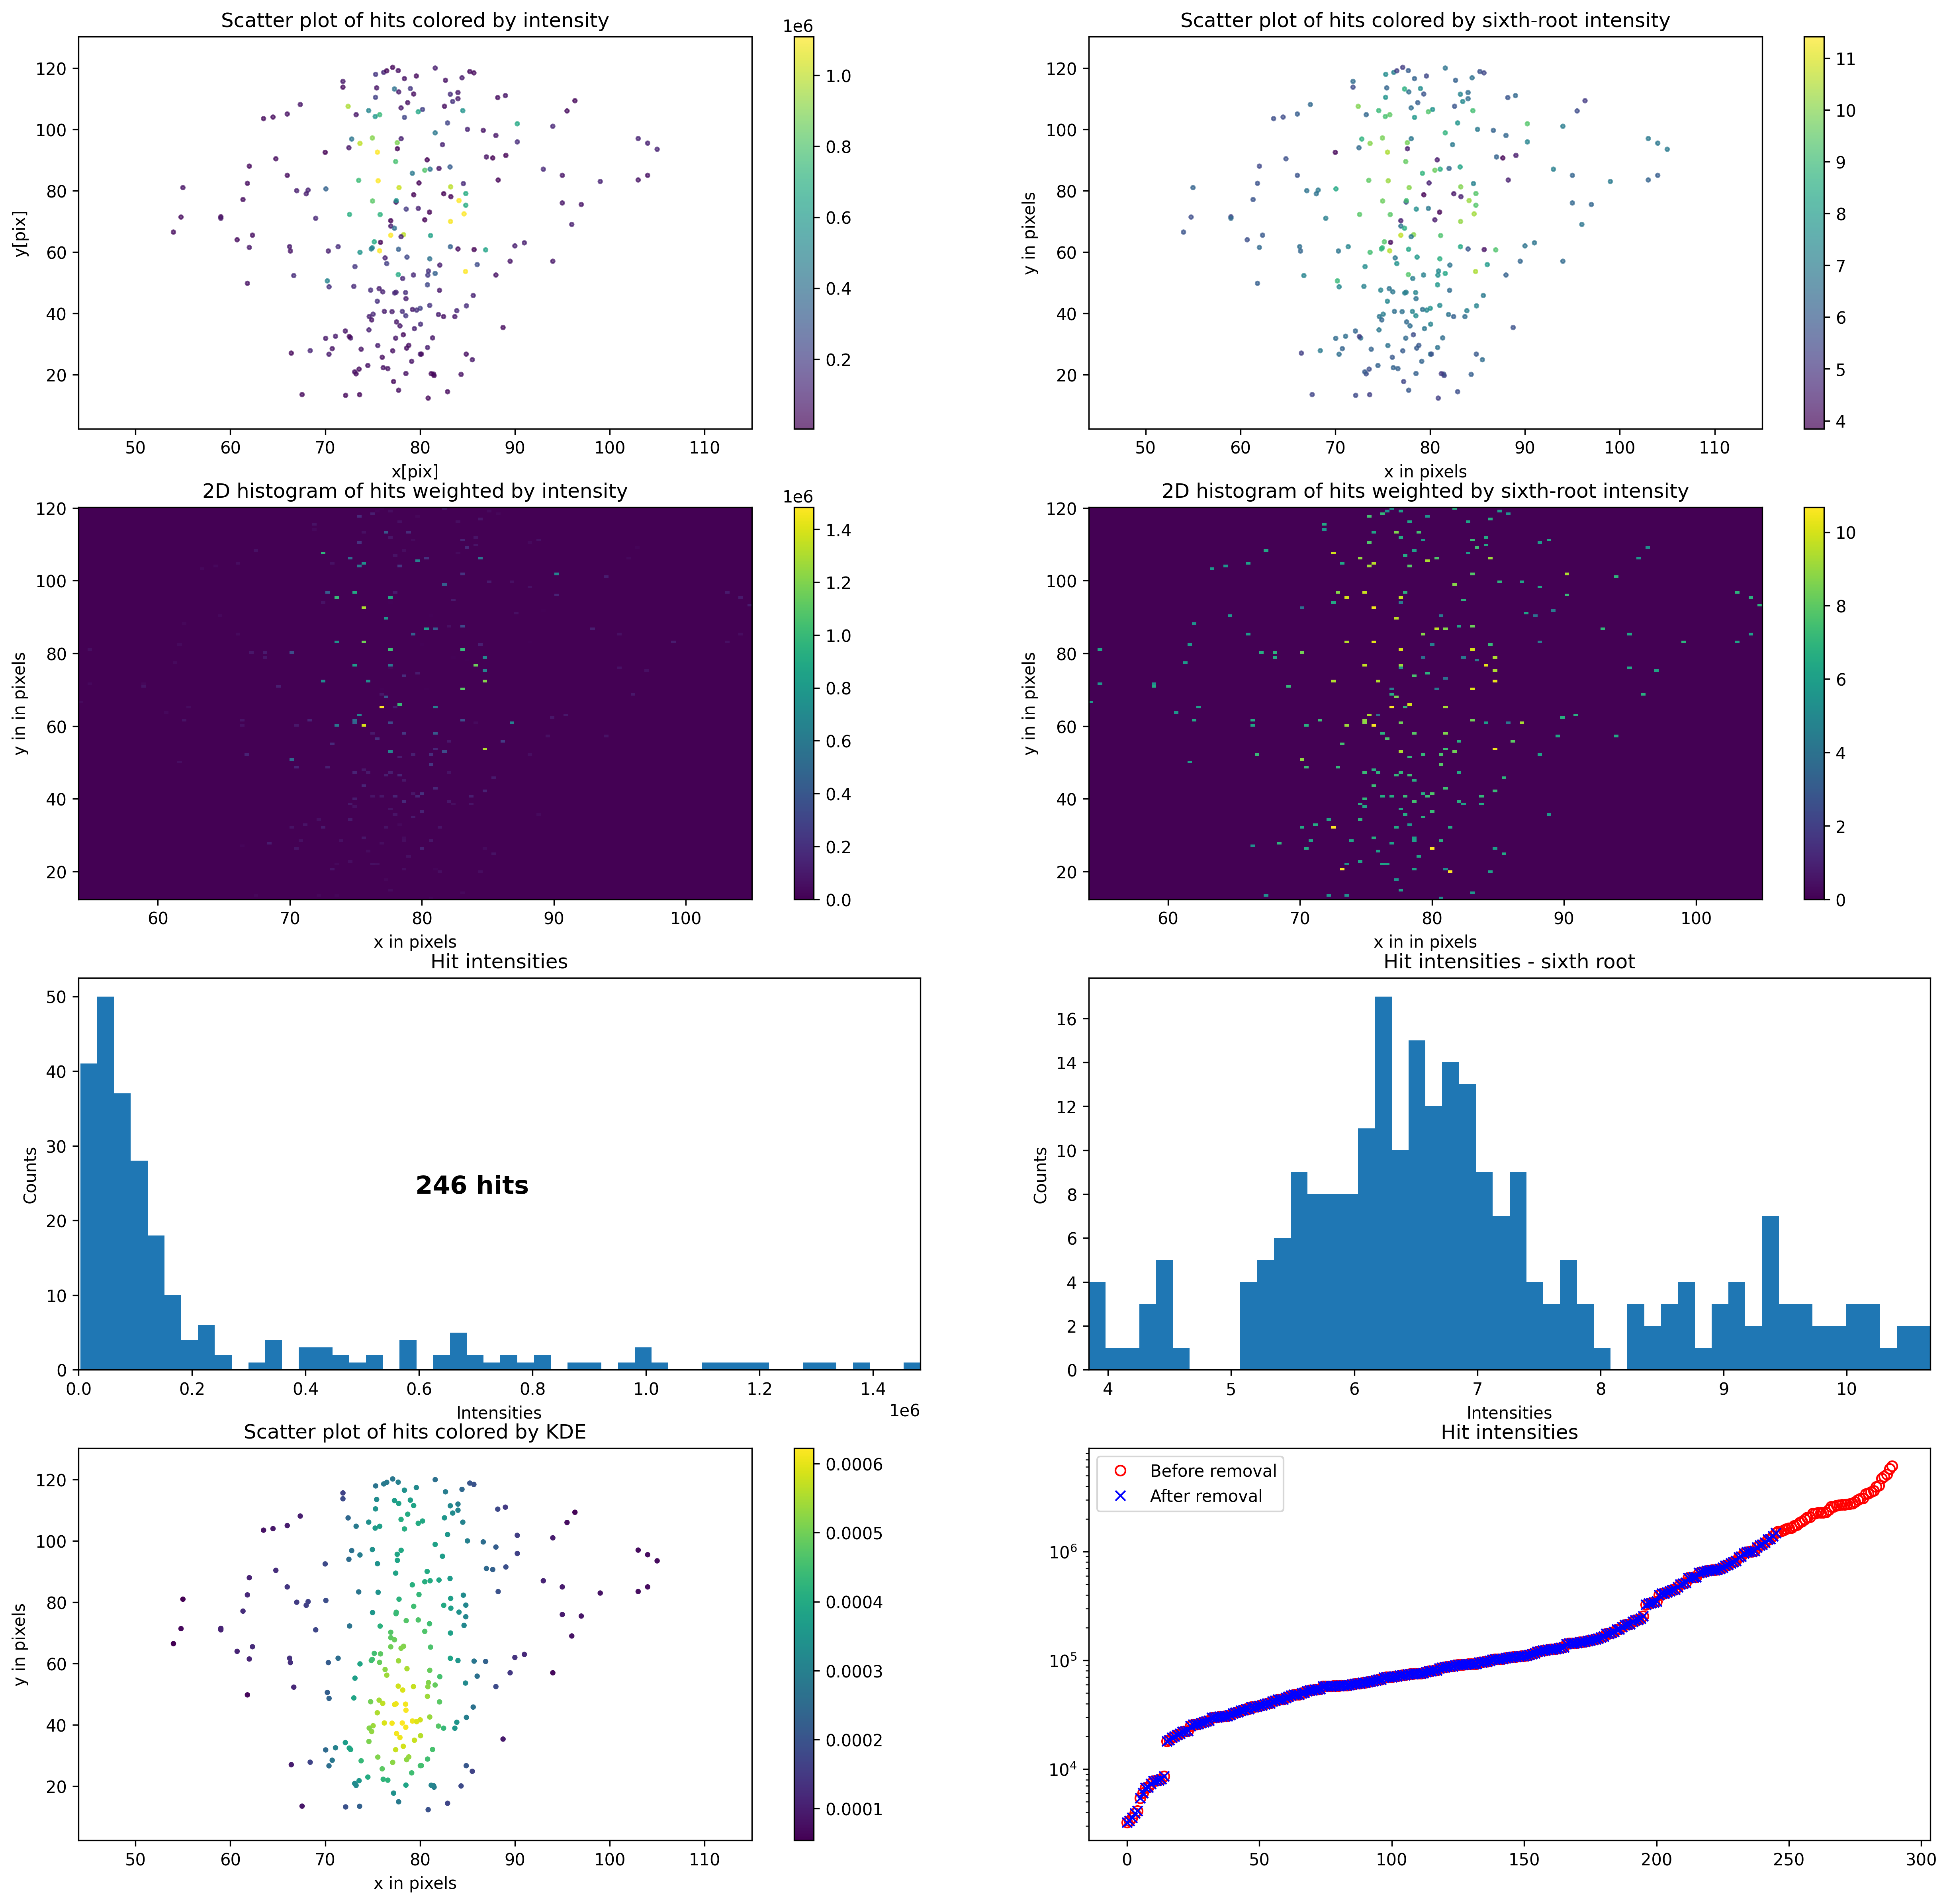

In [23]:
fig, ax = plt.subplots(4 , 2, figsize = (20, 20), dpi = 300) 

xmin = hitx.min() 
xmax = hitx.max() 
ymin = hity.min() 
ymax = hity.max() 
xy = np.vstack([hitx,hity]) 

z_kde = gaussian_kde(xy) 
max_kde = z_kde(xy).max() 

xgrid, ygrid = np.mgrid[xmin:xmax:500j, ymin:ymax:500j] 
xyg = np.vstack([xgrid.ravel(), ygrid.ravel()]) 
z_kde_grid = np.reshape(z_kde(xyg).T, xgrid.shape) 

c = 'viridis' 
num_bins = 50 

xpmin = xmin - 10 
ypmin = ymin - 10 

xpmax = xmax + 10 
ypmax = ymax + 10 

text_hits = str(hits_remain) + " hits"

s1 = ax[0,0].scatter(hitx , hity , c = hits_corrected, s = 5, 
                     cmap = c, alpha = 0.7, vmin = np.min(hits_corrected), vmax = np.mean(hits_corrected) + 3 * np.std(hits_corrected)) 
ax[0,0].set_ylim(ypmin, ypmax) 
ax[0,0].set_xlim(xpmin, xpmax)
ax[0,0].set_xlabel('x[pix]') 
ax[0,0].set_ylabel('y[pix]') 
ax[0,0].set_title('Scatter plot of hits colored by intensity') 
fig.colorbar(s1, ax = ax[0,0]) 

s2 = ax[0,1].scatter(hitx , hity , c = hits_sixth_root, s = 5, cmap = c, alpha = 0.7 , 
                     vmin = np.min(hits_sixth_root), vmax = np.mean(hits_sixth_root) + 3 * np.std(hits_sixth_root)) 
ax[0,1].set_ylim(ypmin, ypmax) 
ax[0,1].set_xlim(xpmin, xpmax)
ax[0,1].set_xlabel('x in pixels') 
ax[0,1].set_ylabel('y in pixels') 
ax[0,1].set_title('Scatter plot of hits colored by sixth-root intensity') 
fig.colorbar(s2, ax = ax[0,1]) 

s3 = ax[1,0].hist2d(hitx, hity, bins = 150, weights = hits_corrected, vmin = 0, vmax = np.max(hits_corrected)) 
ax[1,0].set_xlabel('x in pixels') 
ax[1,0].set_ylabel('y in in pixels') 
ax[1,0].set_title('2D histogram of hits weighted by intensity') 

fig.colorbar(s3[3], ax = ax[1,0]) 

s4 = ax[1,1].hist2d(hitx, hity, bins = 150, weights = hits_sixth_root, vmin = 0, vmax = np.max(hits_sixth_root)) 
ax[1,1].set_xlabel('x in in pixels') 
ax[1,1].set_ylabel('y in in pixels') 
ax[1,1].set_title('2D histogram of hits weighted by sixth-root intensity') 
fig.colorbar(s4[3], ax = ax[1,1]) 

ax[2,0].hist(hits_corrected, bins = num_bins) 
ax[2,0].set_title('Hit intensities') 
ax[2,0].set_xlim(np.min(hits_corrected), np.max(hits_corrected)) 
ax[2,0].set_xlabel('Intensities') 
ax[2,0].set_ylabel('Counts') 
ax[2,0].set_xlim(0, np.max(hits_corrected)) 
ax[2,0].annotate(text_hits, xy = (0.4,0.45), xycoords = 'axes fraction', weight = "bold", size = 15)

ax[2,1].hist(hits_sixth_root, bins = num_bins) 
ax[2,1].set_xlim(np.min(hits_sixth_root), np.max(hits_sixth_root)) 
ax[2,1].set_title('Hit intensities - sixth root') 
ax[2,1].set_xlabel('Intensities') 
ax[2,1].set_ylabel('Counts') 

s5 = ax[3,0].scatter(hitx , hity , c = z_kde(xy), s = 5, alpha = 1.0) 
ax[3,0].set_ylim(ypmin, ypmax) 
ax[3,0].set_xlim(xpmin, xpmax) 
ax[3,0].set_xlabel('x in pixels') 
ax[3,0].set_ylabel('y in pixels') 
ax[3,0].set_title('Scatter plot of hits colored by KDE') 
fig.colorbar(s5, ax = ax[3,0]) 

ax[3,1].plot(np.sort(hit_intensities), 'ro', markerfacecolor = "None", markeredgecolor = "red") 
ax[3,1].set_title("Hit intensities") 
ax[3,1].set_yscale("log") 
ax[3,1].plot(np.sort(hits_corrected), 'bx', markerfacecolor = "None", markeredgecolor = "blue") 
ax[3,1].legend(["Before removal", "After removal"]);

num = 20 
save_name = 'hit_density_' + str(num) + '.pdf'

plt.savefig(save_name) 

<h1> Scatter plot of hits </h1>
The hits are colored per frame with the color denoting the frame number. This is useful when disentangling weird hit results.`

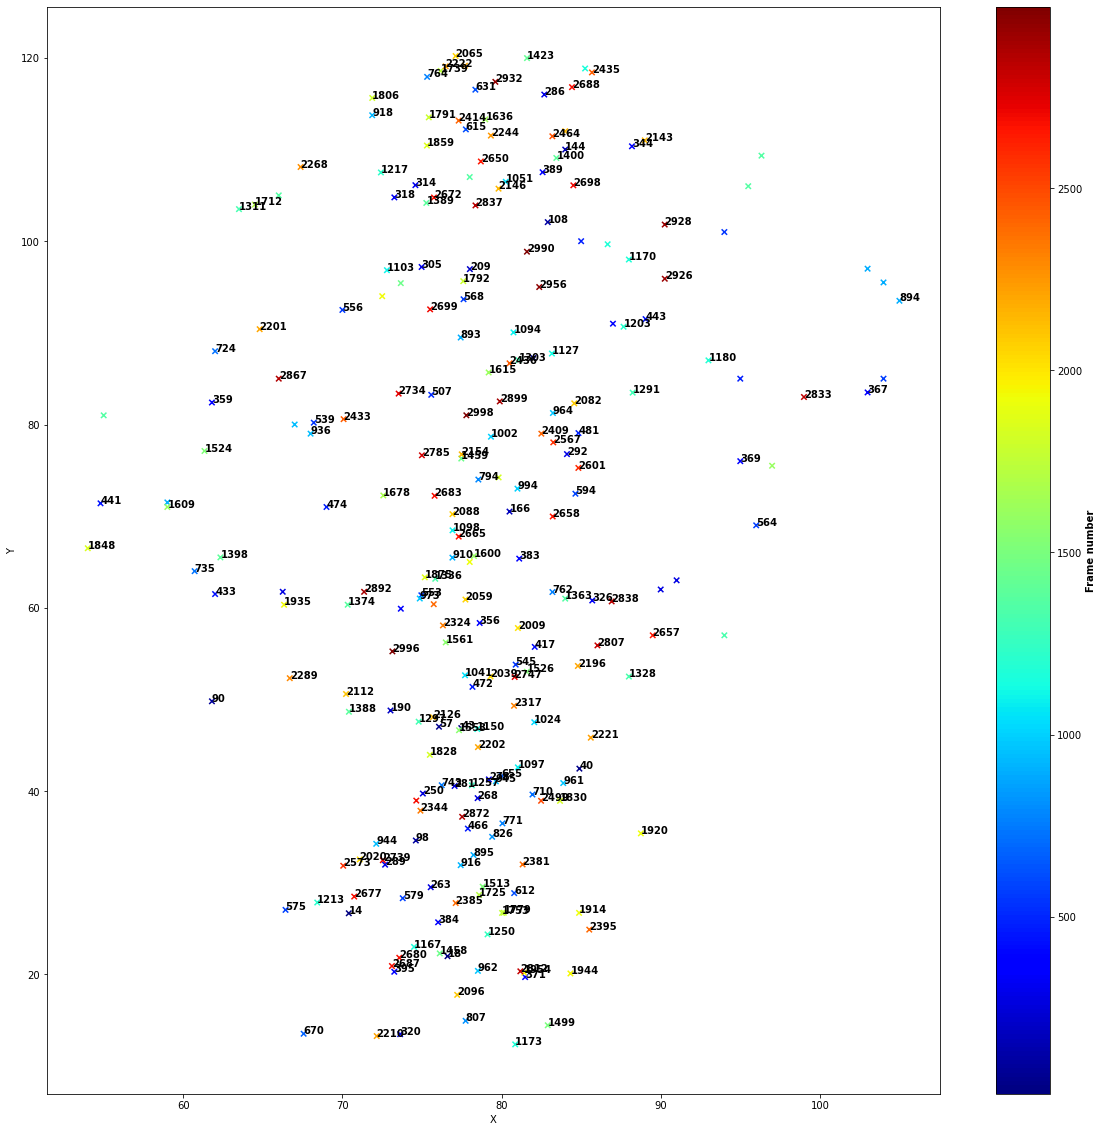

In [16]:
hit_frame_s = np.char.mod("%d", hitframe) # corrected string array for denoting frame number of hit 

plt.figure(figsize = (20, 20)) 
scat_frames = plt.scatter(hitx , hity , s = 30, c = hitframe, cmap = "jet", marker = "x") 
plt.xlabel("X") 
plt.ylabel("Y") 
c_bar = plt.colorbar() 
c_bar.set_label("Frame number", weight = "bold") 

enableAnnotation = True  
if enableAnnotation: 
    o_frame = -1 
    for point, text in enumerate(hit_frame_s): 
        c_frame = int(text) 
        if c_frame != o_frame: 
            plt.annotate(text, (hitx[point], hity[point]), weight = "bold") 
        o_frame = c_frame 

<h1>Calibration curve fitting </h1>
Down below, once the data analysis has been perfected (meaning more-or-less fixed parameters for different particle sizes) we can start constructing calibration curves
and with a nice R2 value we can also confirm particles not measured by extracting back from the curve to particle diameter.

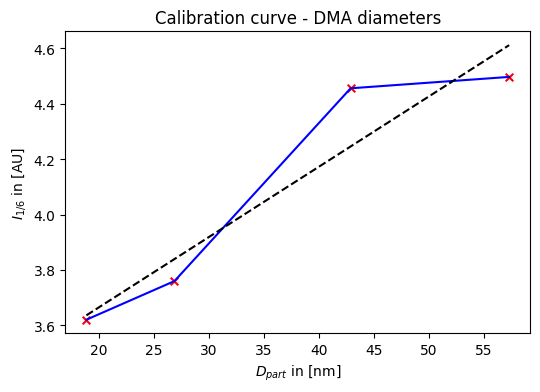

In [8]:
### Constructing calibration curve and performing linear fit 

# Before summer hit analysis
#diams = np.array([15, 15, 20, 20, 30, 40, 50]) 
#intens = np.array([2.3350892460854724, 2.3645170265332958, 3.2252841338754332 , 3.383917731093221, 3.2527086137541024, 3.867076605359937, 4.697551324228289]) 

# After summer hit analysis
diams_all = np.array([20, 30, 40, 50, 100, 100, 125])
intens_all = np.array([3.620308967737568, 3.759820640583048, 4.456153149609946, 4.497299198558576, 
                       4.409813692386593, 5.292829959138102, 4.965295668734437])
stds_all = np.array([0.43533549382480924, 0.46509378831827386, 0.8371922964762603, 0.9260964306721174, 
                    0.47595520068055824, 1.1041174240515332, 0.8089485611891547])

diam_small = np.array([20, 30, 40, 50])
diam_small_dma = np.array([18.9, 26.9, 42.9, 57.3]) # DMA sizes
intens_small = np.array([3.620308967737568, 3.759820640583048, 4.456153149609946, 4.497299198558576])

# Select diameters and intensities to plot and fit 
d_part_s = diam_small
d_part = diam_small_dma 
i_part = intens_small 

# Linear regression on the particle diameter and sixth root intensity data 
a_parts, b_parts, r_parts, p_v, std_err = scipy.stats.linregress(d_part, i_part) 

fig, ax = plt.subplots(dpi = 100) 
ax.plot(d_part, i_part, 'b') 
ax.plot(d_part, (a_parts * d_part + b_parts), '--k') 

ax.scatter(d_part, i_part, s = 30, c = 'r', marker = 'x') # dma 
ax.set_title("Calibration curve - DMA diameters") 
ax.set_xlabel("$D_{part}$ in [nm]") 
ax.set_ylabel("$I_{1/6}$ in [AU]"); 

In [9]:
print("------------------------------------------------------")
print("Linear regression summary:")
print("------------------------------------------------------")
print('slope:', a_parts) 
print('intercept:', b_parts) 
print("correlation coefficient or r-value: %s" % (r_parts))
print('p-value:', p_v) 
print('standard error:', std_err)  
print("------------------------------------------------------")
print() 

------------------------------------------------------
Linear regression summary:
------------------------------------------------------
slope: 0.025415167564125977
intercept: 3.155741873031686
correlation coefficient or r-value: 0.9478894475823093
p-value: 0.05211055241769069
standard error: 0.006040394202207704
------------------------------------------------------



(3000, 268, 196)
[]
(0,)


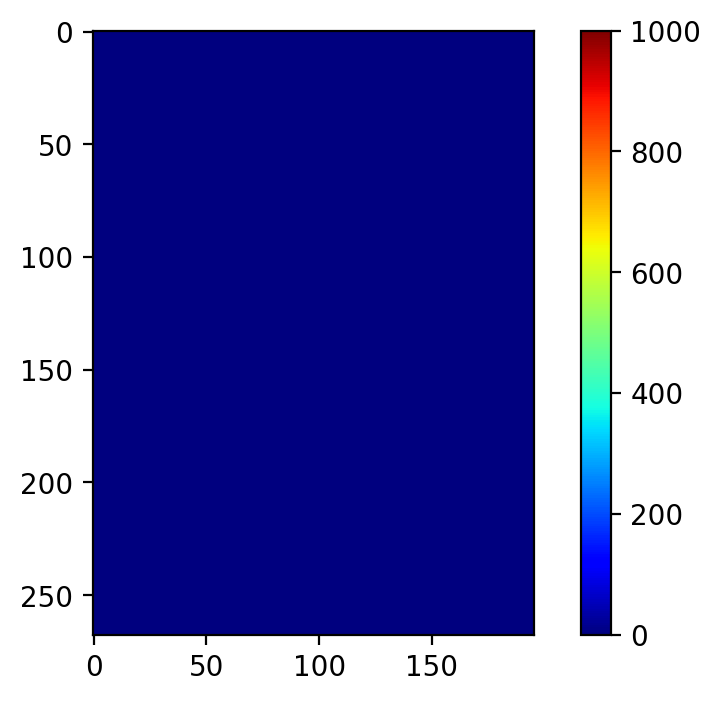

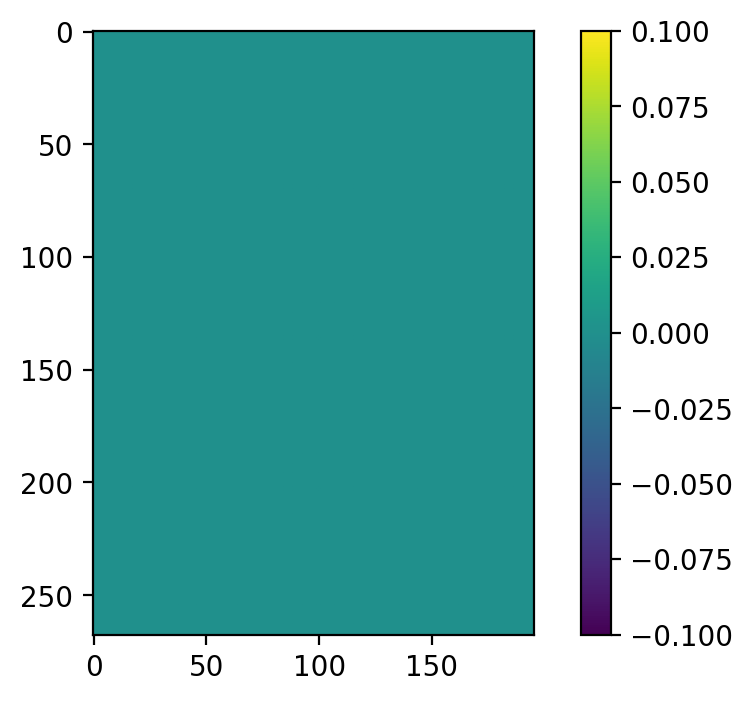

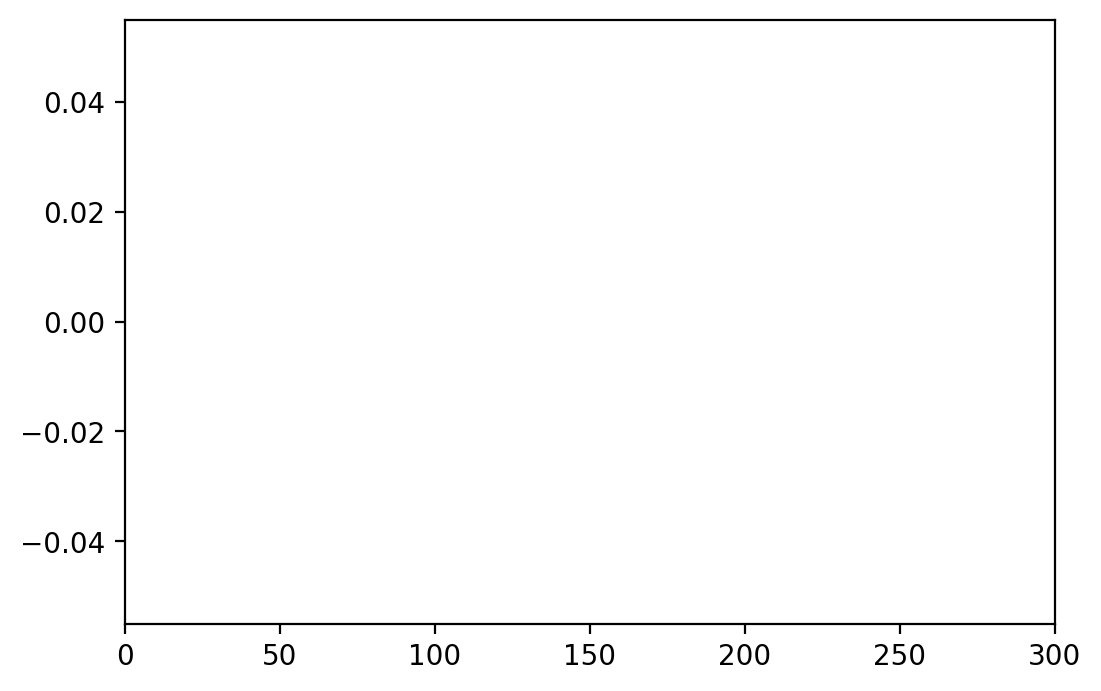

In [57]:
# Inspecting the masked images 
masked_hits = f['/6_analyse/masked_image']
print(masked_hits.shape) 

#sel_hits = masked_hits[70, 90:130, 40:80] 
#sel_hits = masked_hits[81, 100:140, 70:140]
#sel_hits = masked_hits[0, 60:110, 80:110]
sel_hits = masked_hits[307, :, :]

plt.figure(1, dpi = 200) 
plt.imshow(sel_hits, vmin = 0, cmap = 'jet', vmax = 1000, interpolation = None) 
plt.colorbar(); 

bool_hits = sel_hits > 0 

plt.figure(2, dpi = 200) 
plt.imshow(bool_hits, interpolation = None) 
plt.colorbar() 

selected_hits = sel_hits[bool_hits] 

plt.figure(3, dpi = 200) 
plt.hist(selected_hits, bins = 50) 
plt.xlim([0, 300]); 

print(selected_hits) 
print(selected_hits.shape)

In [ ]:
# Closing the file 
f.close() 